In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

from scipy.integrate import quad, solve_ivp, odeint
from scipy.optimize import root_scalar, newton, toms748
from scipy.interpolate import CubicSpline
from numpy import pi, sqrt, exp, arcsinh, log as ln

plt.rcParams['mathtext.fontset'] = 'cm'
font = {'family' : 'serif', 
        'size': 20}
plt.rc('font', **font)
plt.rc('lines', lw=2)

/home/martin/.local/lib/python3.8/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [3]:
x0 = 1e-4

def p_para(x): 
    # if x<x0: print("a")
    return (2*x**3 - 3*x) * sqrt(x**2 + 1) + 3 * arcsinh(x)

def u_para(x):
    # if x<x0: print("b")
    return (2*x**3 + x) * sqrt(x**2 + 1) - arcsinh(x)

# p_para = np.vectorize(p_para)
# u_para = np.vectorize(u_para)

In [4]:
x = sp.Symbol("x")

p_s = (2 * x**3 - 3*x)*sp.sqrt(1+x**2) + 3*sp.asinh(x)
fprime = p_s.diff(x).simplify()
fprime = sp.lambdify(x, fprime)

def u(p0, x0=1, acc=False):
    if p0<0: return 0
    f = lambda x: p_para(x) - p0
    x = root_scalar(f, bracket=(0, 1e3), fprime=fprime).root
    # x = newton(f, x0, fprime=fprime)
    # x = toms748(f, 1e-4, 1e2)
    u0 = u_para(x)
    assert u0>=0
    if acc:print(p_para(x)-p0)
    return u0

uv = np.vectorize(u)
print(u(1e-1,acc=True))

7.494005416219807e-16
0.5919742648957464


In [5]:
def dmdr(r, y, args):
    p, m = y
    return u(p) * r**2

def dpdr(r, y, args):
    p, m = y
    if r<1e-10:
        p0 = args
        u0 = u(p0)
        return - r * (p + u0) * (p + u0) / (1 - 2 * u0 * r )
    else:
        Dp = - (p + u(p)) * (p * r**3 + m) /  (1 - 2 * m/r ) / r**2
        return Dp

In [6]:
def f(r, y, args):
    return dpdr(r, y, args), dmdr(r, y, args)

def stop(r, y, args):
    p, m = y
    return p
stop.terminal = True


In [7]:
def sim(p0 = 0.01):
    return solve_ivp(f, (0, 1e10), (p0, 0), args=(p0,), events=stop, dense_output=True)

In [8]:
s = sim(1)

In [9]:
s

  message: 'A termination event occurred.'
     nfev: 122
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7f49d85289a0>
   status: 1
  success: True
        t: array([0.00000000e+00, 1.00000000e-04, 1.10000000e-03, 1.11000000e-02,
       1.00856995e-01, 2.02259270e-01, 3.42937074e-01, 5.23246754e-01,
       7.38145862e-01, 8.92112883e-01, 1.04607990e+00, 1.19886650e+00,
       1.35165310e+00, 1.48974911e+00, 1.58243948e+00, 1.67512986e+00,
       1.76059466e+00, 1.79066921e+00])
 t_events: [array([1.79066921])]
        y: array([[ 1.00000000e+00,  9.99999962e-01,  9.99995377e-01,
         9.99529376e-01,  9.61906251e-01,  8.55479667e-01,
         6.39265835e-01,  3.56124251e-01,  1.34115565e-01,
         5.74046661e-02,  2.22033418e-02,  7.76166301e-03,
         2.29210994e-03,  5.43550037e-04,  1.46959437e-04,
         3.43953146e-05,  6.05332596e-06, -1.10114283e-20],
       [ 0.00000000e+00,  9.63726537e-13,  1.28271746e-09,
         1.31775

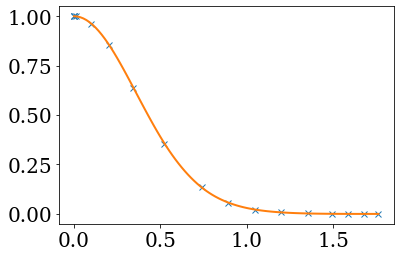

In [10]:
n = -1
r = s.t[:n]
p = s.y[0][:n]

spline = CubicSpline(r, p)
plt.plot(r, p, "x")
r1 = np.linspace(r[0], r[-1], 100)
plt.plot(r1, spline(r1))


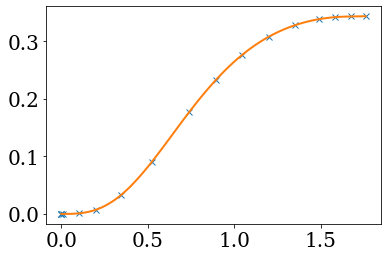

In [11]:
m = s.y[1][:n]
spline = CubicSpline(r, m)
 
plt.plot(r, m, "x")
plt.plot(r1, spline(r1))

In [12]:
def sim_many():
    N = 100
    p0s = 10**np.linspace(-8, 2, N)

    M = np.zeros(N)
    R = np.zeros(N)

    for i, p0 in enumerate(p0s):
        s = solve_ivp(f, (0, 1e3), (p0, 0), args=(p0,), events=stop)
        rs = s.t
        ps, ms = s.y
        M[i] = ms[-1]
        R[i] = rs[-1]

    return R, M


In [13]:
R, M = sim_many()

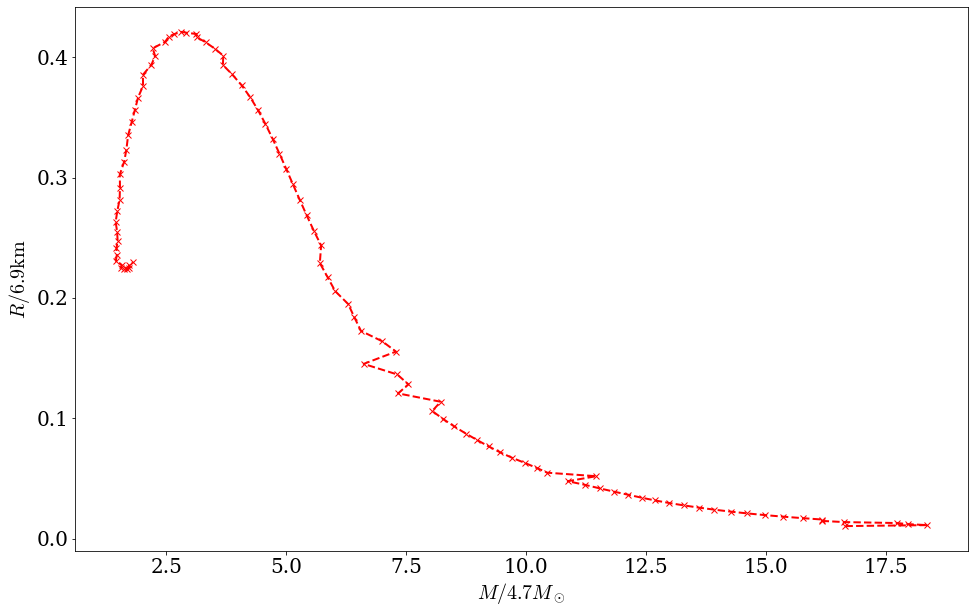

In [14]:
Rs = np.linspace(0.2, 1.1, 100)

fig, ax = plt.subplots(figsize=(16,10))

# ax.plot(Rs,  4 / 9 * Rs, "k--")
ax.plot(R, M, "r--x")

ax.set_ylabel(r"$R / 6.9 \mathrm{km}$")
ax.set_xlabel(r"$M / 4.7 M_\odot$")

plt.show()

In [737]:
M[68]*4.66/sqrt(3)

1.1326053384291994